<div class="alert alert-block alert-warning"> <b>Authors and Reviewers</b>. This is the notebook version for review. We will remove this markdown cell after the peer-review. </div>

# Live-stock detection (DeepForest)
## Context
### Purpose
Implement and fine-tune a prebuilt Deep Learning model to detect livestock in airborne imagery. The model is implemented using PyTorch Lightning, which simplifies the training process and allows for easy checkpointing, enabling collaborative work by saving and sharing model progress.

### Modelling Approach
The [live-stock detection model](https://huggingface.co/weecology/deepforest-livestock) from the latest version (v1.4.0) of the [DeepForest](https://deepforest.readthedocs.io/en/latest/) Deep Learning model is used to predict bounding boxes corresponding to cattle from airborn RGB images.

As a PyTorch Lightning module, this model can be fine-tuned easily, and checkpoints can be saved as [.safetensors](https://huggingface.co/docs/safetensors/index), making it possible to upload the trained models to platforms like Hugging Face for open collaboration.

The prebuilt model was trained on a [limited dataset](https://new.wildlabs.net/discussion/global-model-livestock-detection-airborne-imagery-data-applications-and-needs). According to the package's documentation, "the prebuilt models will always be improved by adding data from the target area". As such, this notebook will explore the improvement in the model's performance in live-stock detection from fine-tuning on local data.

### Description
This notebook will explore the capabilities of the DeepForest package. In particular, it will demonstrate how to:

- Detect livestock in airborne imagery using the prebuilt livestock detection model.
- Fine-tune the model using a novel publicly-available dataset.
- Evaluate the model's performance before and after fine-tuning.
- Save and share model checkpoints throughout the process, allowing for reproducibility and collaboration on Hugging Face.

### Highlights
The prebuilt model was trained on 2585 training and 808 validation annotations, and its performance metrics on the test set (subset of images excluded from training/validation sets) showed substantial gains:

- Box Recall: Improved from 0.4405 to 0.9535.
- Box Precision: Improved from 0.5826 to 0.8587.
- Mean IoU: Improved from 0.3135 to 0.6571.

These results demonstrate the potential of improving the model further by sharing checkpoints as open-source models on Hugging Face, enabling collaborative enhancements based on additional local data.

### Contributions
#### Notebook
* Cameron Appel (author), Queen Mary University of London, @camappel

#### Modelling codebase
* Ben Weinstein (maintainer & developer), University of Florida, @bw4sz
* Henry Senyondo (support maintainer), University of Florida, @henrykironde
* Ethan White (PI and author), University of Florida, @weecology


## Import libraries

In [ ]:
!pip -q install deepforest==1.4.0

In [1]:
import os
import glob
import urllib

import numpy as np
import pandas as pd

import xmltodict
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from deepforest import main
from deepforest.visualize import plot_predictions
from huggingface_hub import hf_hub_download

import torch

from shapely.geometry import box
from skimage.exposure import equalize_hist

import pooch

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

## Set project structure
The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder.

In [2]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

In [3]:
extract_dir = os.path.join(notebook_folder, 'test_data')
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)

# Fetch RGB images from Zenodo

Fetch sample images and ground-truth labels from [Zenodo](https://zenodo.org/records/13851270).

Data were sourced from Harvard's publicly accessible [ODjAR Dataverse](https://dataverse.harvard.edu/dataverse/ODjAR). Specifically, G.J. Franke; Sander Mucher, 2021, "Annotated cows in aerial images for use in deep learning models", which includes "a large dataset containing aerial images from fields in Juchowo, Poland and Wageningen, the Netherlands, with annotated cows present in the images using Pascal VOC XML Annotation Format."

Given that this dataset is stored as a multi-part archive, it was necessary to download and unzip the files separately using `pyunpack`, then distribute the test subset on Zenodo.

- Images are `.jpg` files
- Ground-truth labels are represented by `test.csv` (image_path, xmin, ymin, xmax, ymax, label)

In [4]:
unzipped_files = pooch.retrieve(
    url="doi:10.5281/zenodo.13851270/test_data.zip",
    known_hash="6a0a5b48fc9326e97c3cd8bdcabc2bcd131f3755f6ceabbf6976aefbfc87fb00",
    processor=pooch.Unzip(extract_dir=extract_dir),
    path=f"."
)

In [5]:
# Load the CSV (annotations)
test_path = [file for file in unzipped_files if file.endswith('test.csv')][0]
test_df = pd.read_csv(test_path)

# Download baseline model

Download the baseline livestock detection model from Hugging Face using the load_model function provided by DeepForest. This function allows us to load pretrained models, including custom revisions, directly from Hugging Face.

The model weights are saved in the [.safetensors](https://huggingface.co/docs/safetensors/index) format. Safetensors is a relatively new format, introduced in late 2022 by Hugging Face. It was developed to address security and performance concerns when loading large models, specifically avoiding the risk of arbitrary code execution that can occur with traditional formats like PyTorch’s .pt or TensorFlow’s .h5.

In [6]:
model = main.deepforest()
model.load_model(model_name="weecology/deepforest-livestock", revision="main")

# Other pre-trained models:
    # - weecology/deepforest-bird
    # - weecology/deepforest-livestock
    # - weecology/everglades-nest-detection
    # - weecology/cropmodel-deadtrees

Reading config file: /Users/acoca/anaconda3/envs/95199651-9e81-4cae-a3a7-66398a9a5f62/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /Users/acoca/anaconda3/envs/95199651-9e81-4cae-a3a7-66398a9a5f62/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


deepforest(
  (model): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=0.0)
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias

# Evaluate baseline performance

The baseline performance of the pretrained livestock detection model is evaluated on the test set.

Using the evaluate method, the model's performance is assessed by calculating key metrics such as __Box Recall__, __Box Precision__, and __Mean IoU__ (Intersection over Union), which indicate how accurately the model detects livestock in the test imagery. This serves as a benchmark to compare improvements after fine-tuning.

In [7]:
model.label_dict = {'cow': 0}  # label defaults to 'tree'; change to 'cow', 'bird', etc.
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)
model.config['workers'] = 0

# Set the directory to save the results of the pretrained model
baseline_save_dir = os.path.join(notebook_folder, 'baseline_pred_result')
os.makedirs(baseline_save_dir, exist_ok=True)

# Evaluate the pretrained model on the test set (using test_file)
baseline_results = model.evaluate(test_path, os.path.dirname(test_path), iou_threshold=0.4, savedir=baseline_save_dir)

print("Baseline evaluation complete. Results saved to", baseline_save_dir)

Predicting: |          | 0/? [00:00<?, ?it/s]

NotImplementedError: The operator 'torchvision::nms' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [9]:
print("Baseline performance")

print(f"Box Recall: {baseline_results['box_recall']:.4f}")
print(f"Box Precision: {baseline_results['box_precision']:.4f}")

mean_iou = np.mean(baseline_results['results']['IoU'])
print(f"Mean IoU: {mean_iou:.4f}")

Baseline performance
Box Recall: 0.4405
Box Precision: 0.5826
Mean IoU: 0.3135


# Visualise

## Load sample image

In [10]:
# Load the test.csv file
test_csv_path = os.path.join(extract_dir, "test.csv")
df = pd.read_csv(test_csv_path)

# Load the image
image_name = "20181001 (88).JPG"
image_path = os.path.join(extract_dir, image_name)
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

## Plot ground truth

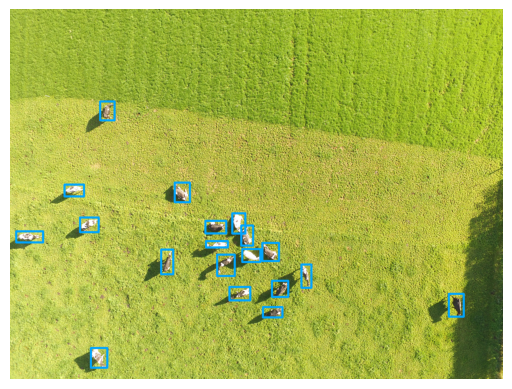

In [11]:
# Filter bounding boxes for the specific image
image_boxes = df[df['image_path'] == image_name]

# Prepare bounding boxes DataFrame for plot_predictions
boxes_df = image_boxes[['xmin', 'xmax', 'ymin', 'ymax', 'label']]

# Plot bounding boxes on the image
annotated_image_truth = plot_predictions(image_np, boxes_df, color=(0, 165, 255), thickness=15)

# Display the image with bounding boxes
plt.imshow(annotated_image_truth)
plt.axis('off')  # Turn off axis to focus on the image
plt.show()

## Plot prediction

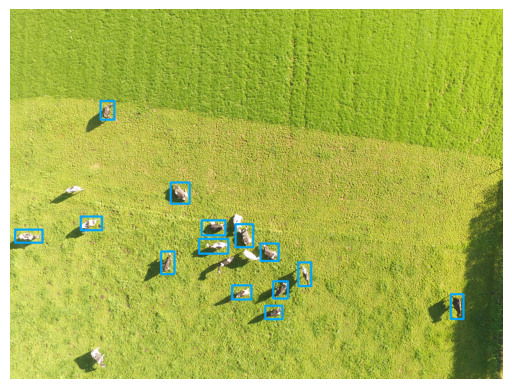

In [12]:
# Assuming baseline_results is already available
predictions_df = baseline_results['predictions']

# Filter predicted boxes for the specific image
image_predictions = predictions_df[predictions_df['image_path'] == image_name]

# Prepare bounding boxes DataFrame for plot_predictions
# Use xmin, ymin, xmax, ymax and label columns from predictions
boxes_df = image_predictions[['xmin', 'xmax', 'ymin', 'ymax', 'label']]

# Plot bounding boxes on the image using deepforest.visualize
annotated_image_base = plot_predictions(image_np, boxes_df, color=(0, 165, 255), thickness=15)

# Display the image with bounding boxes
plt.imshow(annotated_image_base)
plt.axis('off')  # Turn off axis to focus on the image
plt.show()

False negatives can be observed, where the baseline model failed to detect some cows present in the ground truth annotations. This highlights areas where the model's initial performance can be improved through fine-tuning using local data to reduce these missed detections.

# Train model
Since the Binder environment does not provide enough computational resources for training the model, the following code demonstrates how to set up and train the model in a more powerful local or cloud-based environment using PyTorch Lightning.

```python
    import pytorch_lightning as pl

    output_dir = os.path.join(notebook_folder, 'data')
    test_dir = os.path.join(notebook_folder, 'test_data')

    train_file = os.path.join(output_dir, "train.csv")
    valid_file = os.path.join(output_dir, "valid.csv")
    test_file = os.path.join(test_dir, "test.csv")

    model.label_dict = {'cow': 0}  # Rename label

    # Configure the model for GPU usage and set the CSV file paths
    model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)
    model.config["train"]["csv_file"] = train_file  # Path to training CSV
    model.config["train"]["root_dir"] = os.path.dirname(train_file)  # Root directory for training images
    model.config["score_thresh"] = 0.4  # Set score threshold
    model.config["train"]['epochs'] = 5  # Number of epochs
    model.config["validation"]["csv_file"] = valid_file  # Path to validation CSV
    model.config["validation"]["root_dir"] = os.path.dirname(valid_file)  # Root directory for validation images

    early_stopping = EarlyStopping(monitor='box_recall', patience=2, mode='max')

    callback = ModelCheckpoint(
        dirpath='checkpoints/',  # Directory to save checkpoints
        monitor='box_recall',  # Metric to monitor
        mode="max",  # Save when the metric is maximized
        save_top_k=3,  # Save the top 3 checkpoints
        filename="box_recall-{epoch:02d}-{box_recall:.2f}"  # File name format for checkpoints
    )

    logger = TensorBoardLogger(save_dir='logdir/')

    model.create_trainer(logger=TensorBoardLogger(save_dir='logdir/'),
                                    callbacks=[callback, early_stopping])

    model.trainer.fit(model)
```

After training the model, the following code saves the fine-tuned model checkpoint to a specified directory, ensuring that the model's progress can be easily reloaded or shared for further use. The checkpoint is saved in .ckpt format using PyTorch Lightning's save_checkpoint method.

```python
    checkpoint_dir = './drive/MyDrive/notebook/checkpoints_ckpt'
    os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save the model checkpoint as .ckpt
    checkpoint_path = "{}/finetuned_checkpoint.ckpt".format(checkpoint_dir)

    # Save the checkpoint after training using PyTorch Lightning's save_checkpoint method
    model.trainer.save_checkpoint(checkpoint_path)
```

# Load finetuned model

In [13]:
# Download the finetuned model checkpoint from Hugging Face
ckpt_path = hf_hub_download(
    repo_id="camappel/deepforest-livestock",
    filename="finetuned_checkpoint.ckpt"
)

model = main.deepforest.load_from_checkpoint(ckpt_path)

print("Finetuned model loaded successfully!")

finetuned_checkpoint.ckpt:   0%|          | 0.00/257M [00:00<?, ?B/s]

Reading config file: /srv/conda/envs/notebook/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Finetuned model loaded successfully!


# Evaluate finetuned performance

The evaluate method assesses the fine-tuned model’s performance on the test dataset, with results stored for comparison against the baseline.

In [14]:
model.label_dict = {'cow': 0}  # Assign a unique integer ID to the 'cow' label
model.config['gpus'] = '-1'  # Use GPU (set to '0' for the first GPU or '-1' for all GPUs)
model.config['workers'] = 0

# Set the directory to save the results of the pretrained model
finetuned_save_dir = os.path.join(notebook_folder, 'finetuned_pred_result')
os.makedirs(finetuned_save_dir, exist_ok=True)

# Evaluate the pretrained model on the test set (using test_file)
finetuned_results = model.evaluate(test_path, os.path.dirname(test_path), iou_threshold=0.4, savedir=finetuned_save_dir)

print("Finetuned evaluation complete. Results saved to", finetuned_save_dir)

Predicting: |          | 0/? [00:00<?, ?it/s]

Finetuned evaluation complete. Results saved to ./notebook/finetuned_pred_result


In [15]:
print("Finetuned performance")
# Print box recall and precision with clean formatting
print(f"Box Recall: {finetuned_results['box_recall']:.4f}")
print(f"Box Precision: {finetuned_results['box_precision']:.4f}")

# Compute and print the mean IoU, rounded to 4 decimal places
mean_iou = np.mean(finetuned_results['results']['IoU'])
print(f"Mean IoU: {mean_iou:.4f}")

Finetuned performance
Box Recall: 0.9535
Box Precision: 0.8587
Mean IoU: 0.6571


# Visualise

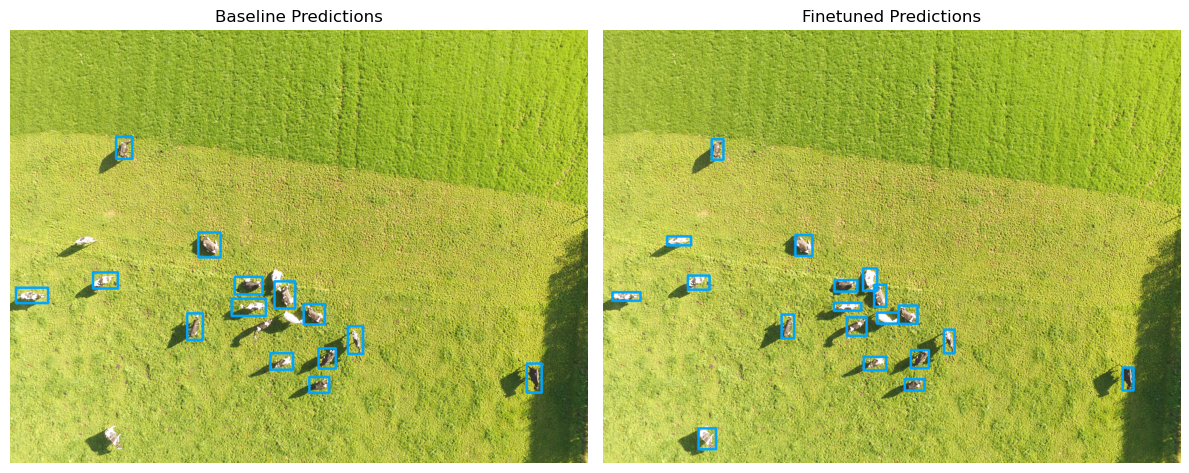

In [16]:
predictions_df = finetuned_results['predictions']

image_predictions = predictions_df[predictions_df['image_path'] == image_name]

# Use xmin, ymin, xmax, ymax and label columns from predictions
boxes_df = image_predictions[['xmin', 'xmax', 'ymin', 'ymax', 'label']]

annotated_image_fine = plot_predictions(image_np, boxes_df, color=(0, 165, 255), thickness=15)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 column layout

axs[0].imshow(annotated_image_base)
axs[0].set_title("Baseline Predictions")
axs[0].axis('off')  

axs[1].imshow(annotated_image_fine)
axs[1].set_title("Finetuned Predictions")
axs[1].axis('off') 

# Show the side-by-side plots
plt.tight_layout()
plt.show()

The fine-tuned model shows a significant improvement, successfully detecting all cows in the test imagery without any false negatives, demonstrating the effectiveness of fine-tuning on local data.

## Summary

This notebook demonstrates the process of fine-tuning the DeepForest livestock detection model, achieving notable performance improvements after training for 5 epochs. The model was fine-tuned on a labeled aerial dataset of cows from Dataverse (2585 training and 808 validation samples). Performance on the test set, which consisted of images excluded from training and validation, showed substantial gains across key metrics:

- Box Recall: Increased from 0.4405 to 0.9535
- Box Precision: Improved from 0.5826 to 0.8587
- Mean IoU: Enhanced from 0.3135 to 0.6571

These results highlight the effectiveness of fine-tuning and open-sourcing, significantly boosting the model's ability to accurately detect livestock in aerial imagery.

## Additional information
**Dataset**: G.J. Franke; Sander Mucher, 2021, "Annotated cows in aerial images for use in deep learning models"

**Codebase**: DeepForest [v1.4.0](https://github.com/weecology/DeepForest)

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [17]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2024-10-30
